# 1.1 Evaluate the Accuracy of Service Metric Estimation

(a) Model Training - use linear regression to train a model M with the training set. Provide the coefficients (Θ 0 , ..., Θ 12 ) of your model M . (Θ 0 is the offset.)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')
Y['TimeStamp'] = Y.TimeStamp.astype(int)

X.index = pd.to_datetime(
    X['TimeStamp'], unit='s')
Y.index = pd.to_datetime(
    Y['TimeStamp'], unit='s')

X_train, X_test, y_train, y_test = train_test_split(
    X.drop(['TimeStamp'], axis=1), Y.drop(['TimeStamp'], axis=1), test_size=0.3)

X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
y_train = y_train.sort_index(axis = 0)
y_test = y_test.sort_index(axis = 0)


regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

print("The coeffiecients of the models are:")
for idx, col_name in enumerate(X_train.columns):
    print("w{} -> The coefficient for {}: {}".format(
        idx + 1, col_name, np.round(
            regression_model.coef_[0][idx], decimals=3)))

intercept = np.round(regression_model.intercept_[0], decimals=3)
print("The bias b: {}".format(intercept))


The coeffiecients of the models are:
w1 -> The coefficient for runq-sz: -0.033
w2 -> The coefficient for %%memused: 0.258
w3 -> The coefficient for proc/s: 0.002
w4 -> The coefficient for cswch/s: -0.0
w5 -> The coefficient for all_%%usr: 0.072
w6 -> The coefficient for ldavg-1: 0.013
w7 -> The coefficient for totsck: 0.001
w8 -> The coefficient for pgfree/s: -0.0
w9 -> The coefficient for plist-sz: -0.009
w10 -> The coefficient for file-nr: 0.003
w11 -> The coefficient for idel/s: 0.0
w12 -> The coefficient for tps: 0.002
The bias b: 16.498


b) Accuracy of Model M - compute the estimation error of M on the test set. We define the estimation error as the Normalized Mean Absolute Error (N M AE).

In [6]:
def get_nmae(y_predict, y_test):
    m = y_test['DispFrames'].count()
    y_mean = y_test['DispFrames'].mean()
    
    sum_abs_y_mean_predict = 0.0
    i = 0
    for _, row in y_test.iterrows():
        sum_abs_y_mean_predict += abs(row['DispFrames'] - y_predict[i][0])
        i += 1

    nmae = (sum_abs_y_mean_predict / m) / y_mean
    return np.round(nmae, decimals=8)

y_predict = regression_model.predict(X_test)
print("NMAE of the prediction model: {}".format(get_nmae(y_predict, y_test)))
y_test_mean = y_test['DispFrames'].mean()  # for naive prediction
print("The naive estimator value or mean of y_test['DispFrames']: {}".format(
    y_test_mean))
y_naive_predict_arr = np.full((y_test['DispFrames'].count(), 1),
                                           y_test_mean)
print("NMAE of the naive prediction model: {}".format(get_nmae(
    y_naive_predict_arr, y_test)))

NMAE of the prediction model: 0.09684122
The naive estimator value or mean of y_test['DispFrames']: 19.392129634485986
NMAE of the naive prediction model: 0.21765562


### Analysis

The naive estimation value is defined as the average of the display frame rates in the test set, which the value is 19.62406481879705. This method predicts that the display rates is always 19.62406481879705 regardless the condition of the other variables from the server machine (in X set).

As the above data shows, the NMAE of the prediction model is 0.09671137 whereas the NMAE for the naive model is 0.21534818. This shows that the prediction model with linear regression is much more accurate than the naive prediction model because the NMAE of the linear regression is around 2.2 times smaller.

c) Produce a time series plot that shows both the measurements and the model estimations for M for the Video Frame Rate values in the test set. Show also the prediction of the a naı̈ve method (see Figure 2)

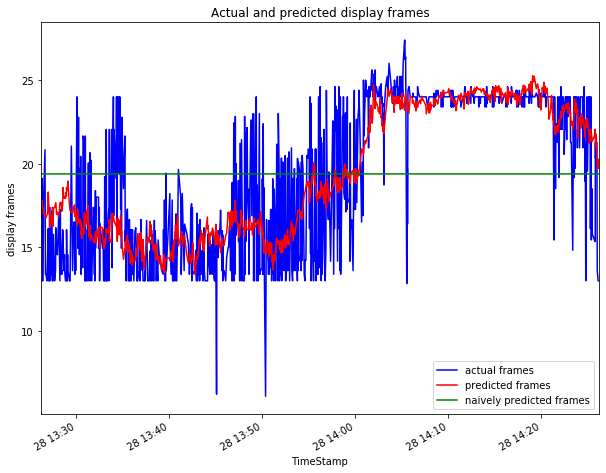

In [7]:
import matplotlib.pyplot as plt

joined_result = y_test.copy()
joined_result['predict'] = y_predict
joined_result['naively_predict'] = y_naive_predict_arr

plt.figure(figsize=(10, 8))
joined_result['DispFrames'].plot(color='blue')
joined_result['predict'].plot(color='red')
joined_result['naively_predict'].plot(color='green')
plt.legend(('actual frames', 'predicted frames', 'naively predicted frames'),
           loc='lower right', shadow=False, fancybox=True)
plt.ylabel('display frames')
plt.title("Actual and predicted display frames")
plt.show()


### Analysis

The graph above shows the actual display frames values in blue line, the prediction of the display frames values in red line, and the naively predicted frames which is basically the average of the display frames in the test set.

The pattern of the prediction plot resembles the actual plot. When the data is fluctuative such as from the time 13:30 to 14:00, the prediction is in the range of the fluctuation. Even from 14:10 to 14:20, when the variation of the display frames is small, the prediction plot is still roughly within the variation. Therefore, the prediction model is quite accurate in predicting the display frames values.

d) Produce a density plot and a histogram for the Video Frame Rate values in the test set

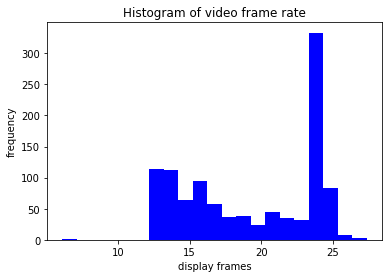

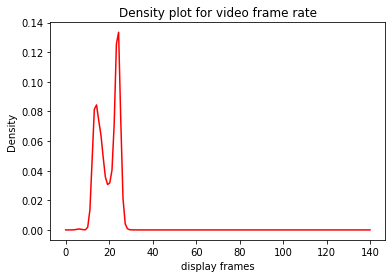

In [13]:
n_bins = int(y_test['DispFrames'].max() - y_test['DispFrames'].min())
plt.xlabel('display frames')
plt.ylabel('frequency')
plt.hist(y_test['DispFrames'], bins=n_bins, color='b', 
    label=['display frames'])
plt.title("Histogram of video frame rate")
plt.show()

y_test['DispFrames'].plot.kde(ind=np.linspace(0, 140, 139), color='r')
plt.xlabel('display frames')
plt.title("Density plot for video frame rate")
plt.show()

### Analysis

These histogram shows that most of the frame rates are between 12 and 25. The density plot shows the bimodal shape. The density plot shows that probably the most values is around 24.

e) Produce a density plot for the prediction error  𝑦𝑖−𝑦̂ 𝑖  in the test set.

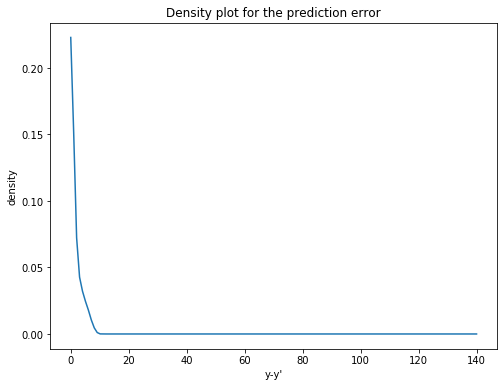

In [12]:
joined_result['estimation_errors'] = np.array(
    [(row['DispFrames'] - row['predict'])
        for _, row in joined_result.iterrows()])

plt.figure(figsize=(8, 6))
joined_result['estimation_errors'].plot.kde(ind=np.linspace(0, 140, 139))
plt.ylabel('density')
plt.xlabel('y-y\'')
plt.title("Density plot for the prediction error")
plt.show()

### Analysis

This density plot shows that the highest probability density function given any value in X axis, which is the difference between the real value and the predicted value, is around 0.22. The plot shows a steep declines toward y-y'=10. After that, the probability density shows value around 0. This means that the model will probably falsely predict no more than 10 rates difference.

# 1.2 Relation between Estimation Accuracy and size of training set

a) From the training set with 2520 observation, create six training sets by selecting uniformly at random 50,100,200, 500,1000 and 2520 observations (which is the original set).

b) Train a linear model and compute the NMAE for each model for the original test set with 1080 observations.

c) Perform the above 50 times, so you train models for 50 different subsets of a given size.

d) Produce a plot that shows NMAE for M against the size of the training set. Use error bars or box plots to show the range of the NMAE values for a given set size.

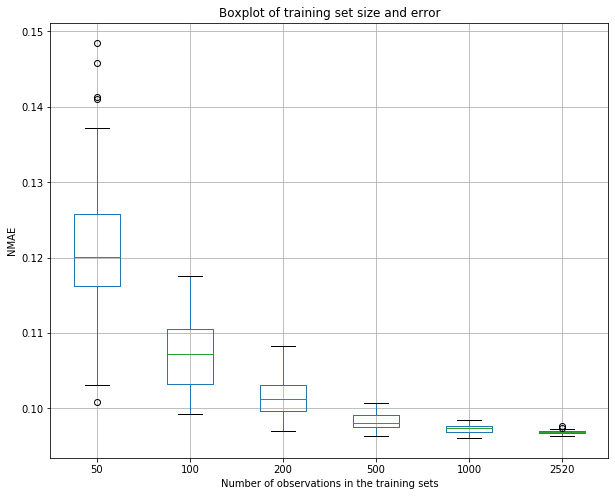

In [14]:
training_test_sizes = [50, 100, 200, 500, 1000, 2520]

nmaes_dict = {}
for train_size in training_test_sizes:
    nmaes = []
    for i in range(0, 50):
        # Split the new training size
        X_train_new, _, y_train_new, _ = train_test_split(
            X.drop(['TimeStamp'], axis=1), 
            Y.drop(['TimeStamp'], axis=1),
            train_size=train_size)
        
        # Build the new model based on the new training size
        regression_model = LinearRegression()
        regression_model.fit(X_train_new, y_train_new)
        
        # predict with the new model, but with the same original 
        # X_test[1080] defined in section 1.1(a)
        y_predict_new = regression_model.predict(X_test) 
        
        # function get_nmae is defined in the first section 1.1, part 2)
        # compute the nmae of the new model with the original y_test value 
        # defined in section 1.1(a)
        nmaes.append(get_nmae(y_predict_new, y_test))
    
    nmaes_dict[train_size] = nmaes

plt.figure(figsize=(10, 8))
nmaes_df = pd.DataFrame(data=nmaes_dict)
nmaes_df.boxplot(column = training_test_sizes)
plt.xlabel('Number of observations in the training sets')
plt.ylabel('NMAE')
plt.title("Boxplot of training set size and error")
plt.show()

The above graph shows the relationship between the Normalized Mean Absolute Error (NMAE) to the number of observations in the tranining sets. The plot shows that the relationship between the number or observations in the training sets the the NMAE resembles the inverse logarithmic function graph. The larger the training set is, the smaller the NMAE will be. This inverse-logarithmic-like relationship shows that the NMAE will saturate at around 0.05. Therefore, even though it's better to have large training sets, when the training sets is larger than 1000, it will not give significant improvement.